In [13]:
# Run this cell to set up the notebook, but please don't change it.

import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


# Data Preparation 

## Salary Data

In [14]:
# Data from textbook
nba_15_16 = Table.read_table('http://inferentialthinking.com/notebooks/nba_salaries.csv')
nba_15_16.show(3)
# From http://www.basketball-reference.com/contracts/
nba_after_16 = Table.read_table('nba_salary.csv')
nba_after_16.show(3)

PLAYER,POSITION,TEAM,'15-'16 SALARY
Paul Millsap,PF,Atlanta Hawks,18.6717
Al Horford,C,Atlanta Hawks,12
Tiago Splitter,C,Atlanta Hawks,9.75625


Rk,Team,2017-18,2018-19,2019-20,2020-21,2021-22,2022-23
1,Golden State Warriors,$137494845,$128341465,$85953438,$43006362,$45780966,nan
2,Cleveland Cavaliers,$137082833,$122521377,$80319306,$3872215,nan,nan
3,Oklahoma City Thunder,$134294056,$137538745,$88281978,$72478103,$43848000,$46662000


In [15]:
nba_salary_15_16 = nba_15_16.drop(0, 1).group('TEAM', sum)
nba_salary_15_16.show(3)
nba_salary0 = nba_salary_15_16.join('TEAM', nba_after_16, 'Team')
nba_salary0 = nba_salary0.select(0, 1, 4)
nba_salary0.show(3)

TEAM,'15-'16 SALARY sum
Atlanta Hawks,69.5731
Boston Celtics,50.2855
Brooklyn Nets,57.307


TEAM,'15-'16 SALARY sum,2018-19
Atlanta Hawks,69.5731,$70622817
Boston Celtics,50.2855,$107433526
Brooklyn Nets,57.307,$86278705


In [16]:
def remove_first_convert_int(string): 
    """Remove the first character of a string and convert it to integer. """
    return int(string[1:])

In [17]:
#Convert everything to the same unit and from string to integer
#Salary in million 
nba_salary = Table().with_columns(
    'Team', nba_salary0.column('TEAM'), 
    '15-16 Salary', nba_salary0.column(1), 
    '16-17 Salary', nba_salary0.apply(remove_first_convert_int, 2) / 1e6
)
nba_salary

Team,15-16 Salary,16-17 Salary
Atlanta Hawks,69.5731,70.6228
Boston Celtics,50.2855,107.434
Brooklyn Nets,57.307,86.2787
Charlotte Hornets,84.1024,118.033
Chicago Bulls,78.8209,62.2379
Cleveland Cavaliers,102.312,122.521
Dallas Mavericks,65.7626,69.61
Denver Nuggets,62.4294,111.77
Detroit Pistons,42.2118,106.08
Golden State Warriors,94.0851,128.341


## Records Data

In [18]:
# From http://www.basketball-reference.com/leagues/NBA_2016_standings.html
records_15_16 = Table.read_table('records_15_16.csv')
records_15_16.show(3)
# From http://www.basketball-reference.com/leagues/NBA_2017_standings.html
records_16_17 = Table.read_table('records_16_17.csv')
records_16_17.show(3)

Rk,Team,Overall,Home,Road,E,W,A,C,SE,NW,P,SW,Pre,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
1,Golden State Warriors,73-9,39-2,34-7,27-3,46-6,9-1,8-2,10-0,15-3,15-1,16-2,48-4,25-5,7-2,44-5,3-0,16-0,11-2,14-2,9-1,15-2,5-2
2,San Antonio Spurs,67-15,40-1,27-14,24-6,43-9,9-1,7-3,8-2,15-3,14-4,14-2,45-8,22-7,4-4,44-6,1-1,13-3,14-2,11-2,11-1,13-3,4-3
3,Cleveland Cavaliers,57-25,33-8,24-17,35-17,22-8,14-4,8-8,13-5,8-2,8-2,6-4,38-14,19-11,4-7,32-8,2-1,11-3,8-5,13-3,8-5,11-5,4-3


Rk,Team,Overall,Home,Road,E,W,A,C,SE,NW,P,SW,Pre,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
1,Golden State Warriors,67-15,36-5,31-10,25-5,42-10,9-1,8-2,8-2,15-3,14-2,13-5,47-9,20-6,3-4,48-6,2-1,14-1,13-3,12-2,9-3,12-4,5-1
2,San Antonio Spurs,61-21,31-10,30-11,25-5,36-16,9-1,8-2,8-2,13-5,12-6,11-5,43-13,18-8,8-5,30-8,4-0,11-4,12-2,10-5,8-2,13-4,3-4
3,Houston Rockets,55-27,30-11,25-16,19-11,36-16,8-2,5-5,6-4,13-5,13-5,10-6,40-18,15-9,8-3,30-11,2-1,9-6,15-2,10-7,6-3,9-6,4-2


In [19]:
# Functions to extract wins and losses
wins_func = lambda string: int(string[:2]) 
losses_func = lambda string: int(string[3:])

In [20]:
wins_15_16 = records_15_16.apply(wins_func, 2)
losses_15_16 = records_15_16.apply(losses_func, 2)
records_15_16_0 = records_15_16.select('Team').with_columns('Wins 15-16', wins_15_16, 'Losses 15-16', losses_15_16)
records_15_16_0.show(3)

wins_16_17 = records_16_17.apply(wins_func, 2)
losses_16_17 = records_16_17.apply(losses_func, 2)
records_16_17_0 = records_16_17.select('Team').with_columns('Wins 16-17', wins_16_17, 'Losses 16-17', losses_16_17)
records_16_17_0.show(3)

records = records_15_16_0.join('Team', records_16_17_0)
records

Team,Wins 15-16,Losses 15-16
Golden State Warriors,73,9
San Antonio Spurs,67,15
Cleveland Cavaliers,57,25


Team,Wins 16-17,Losses 16-17
Golden State Warriors,67,15
San Antonio Spurs,61,21
Houston Rockets,55,27


Team,Wins 15-16,Losses 15-16,Wins 16-17,Losses 16-17
Atlanta Hawks,48,34,43,39
Boston Celtics,48,34,53,29
Brooklyn Nets,21,61,20,62
Charlotte Hornets,48,34,36,46
Chicago Bulls,42,40,41,41
Cleveland Cavaliers,57,25,51,31
Dallas Mavericks,42,40,33,49
Denver Nuggets,33,49,40,42
Detroit Pistons,44,38,37,45
Golden State Warriors,73,9,67,15


## Data for Use

The table below contains all NBA teams with their wins and losses during regular season (excludes playoff) and the total expend for salary in that season. The data includes 15-16 season and 16-17 season. 

In [21]:
nba = records.join('Team', nba_salary)
nba = nba.select(0, 1, 2, 5, 3, 4, 6)
nba.show(3)

Team,Wins 15-16,Losses 15-16,15-16 Salary,Wins 16-17,Losses 16-17,16-17 Salary
Atlanta Hawks,48,34,69.5731,43,39,70.6228
Boston Celtics,48,34,50.2855,53,29,107.434
Brooklyn Nets,21,61,57.307,20,62,86.2787


# Data Visualization

The scatter plots below show the relationship between salary spends in a particular season correspond to numbers of wins. 
By looking at the plots, it seems like there is a positive linear association between salary and number of wins. Namely, if a team pays more for good players, the team is likely to win more games during the regular season. 

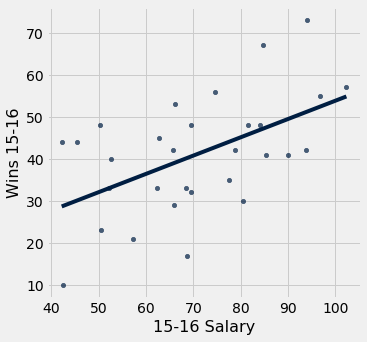

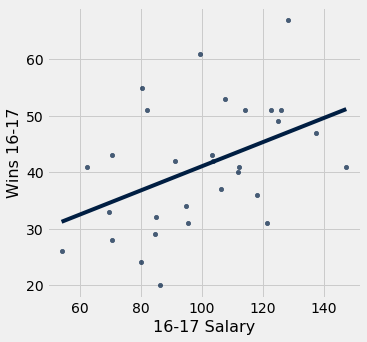

In [22]:
nba.scatter(3, 1, fit_line=True)
nba.scatter(6, 4, fit_line=True)

The bar chart below shows the numbers of wins during 15-16 season and 16-17 season. 
By looking at the chart, we can see if a team's strength change or it's roughly the same. We can even go further to see the ranks of each season, or conduct a hypothesis test to see the change in wins is due to randon chance or a team actually improves. 

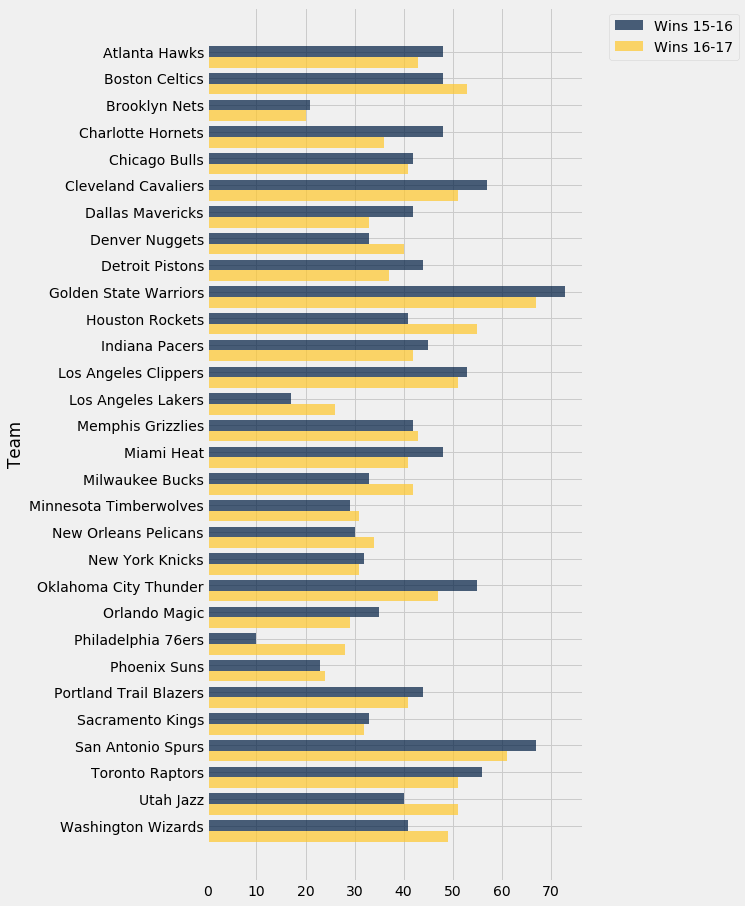

In [23]:
nba.select(0, 1, 4).barh(0)

# Data Exploration 

The two grouping tables below shows the wins and the mean of salary paid for players. We can see the trend that the number of wins increase, the average salary spend also increase although there are some special cases. 

In [24]:
nba.select(1, 3).group('Wins 15-16', np.mean).show()
nba.select(4, 6).group('Wins 16-17', np.mean).show()

Wins 15-16,15-16 Salary mean
10,42.4813
17,68.6079
21,57.307
23,50.5208
29,65.8474
30,80.5146
32,69.405
33,61.0242
35,77.6239
40,52.6319


Wins 16-17,16-17 Salary mean
20,86.2787
24,79.9663
26,53.9158
28,70.5933
29,84.5589
31,108.45
32,84.9291
33,69.61
34,94.8271
36,118.033


# Hypothesis Testing

There is a question in my head. Do the strength of teams (number of wins) change from 15-16 season to 16-17 season? 

Null Hypothesis: The number of wins change from 15-16 season to 16-17 season is due to random chance. 

Alternative Hypothesis: The number of wins change from 15-16 season to 16-17 season is not due to random chance. 

Test Statistic: Mean of absolute value of winnings in 15-16 season minus winnings in 16-17 season. 

In [25]:
nba_wins = nba.select(0, 1, 4)
nba_wins.show(3)

Team,Wins 15-16,Wins 16-17
Atlanta Hawks,48,43
Boston Celtics,48,53
Brooklyn Nets,21,20


## Bootstrap

In [26]:
def abs_change(t, label1, label2): 
    """Compute the absolute change between two column. """
    return np.abs(t.column(label1) - t.column(label2))

def test_stat(t): 
    """Compute the test statistic of the test. The average of absolute change. """
    return np.mean(abs_change(t, 1, 2))


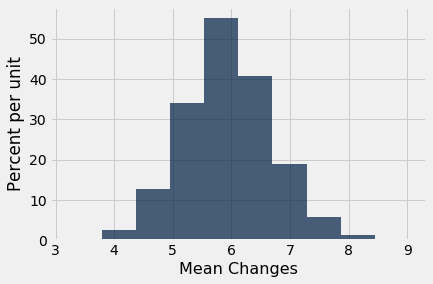

In [27]:
repetition = 5000
mean_changes = []
for _ in np.arange(5000): 
    sample = nba_wins.sample()
    mean_change = test_stat(sample)
    mean_changes.append(mean_change)
Table().with_column('Mean Changes', mean_changes).hist(0)

## 95% Confidence Intervel

In [28]:
lower = round(percentile(2.5, mean_changes), 4)
upper = round(percentile(97.5, mean_changes), 4)
print('A 95% confidence intervel of mean of absolute change in winnings is [{}, {}]'.format(lower, upper) )

A 95% confidence intervel of mean of absolute change in winnings is [4.5, 7.5]


## Conclusion

Based on the test, reject null hypothesis at significance level 0.05. 
Under null hypothesis, the test statistics equals 0, but the confidence intervel conducted does not contain zero. 

# Prediction

## Linear Regression

In this section, I'm interested in the relationship between salary and winnings in 15-16 season. 

In [29]:
nba_1516 = nba.select(0, 1, 3)
nba_1516.show(3)

Team,Wins 15-16,15-16 Salary
Atlanta Hawks,48,69.5731
Boston Celtics,48,50.2855
Brooklyn Nets,21,57.307


In [30]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of ther regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def plot_residuals(t, x, y):
    """Plot a scatter diagram and residuals."""
    t.scatter(x, y, fit_line=True)
    actual = t.column(y)
    fitted = fit(t, x, y)
    residuals = actual - fitted
    print('r:', correlation(t, x, y))
    print('RMSE:', np.mean(residuals**2)**0.5)
    t.select(x).with_column('Residual', residuals).scatter(0, 1)

In [31]:
r = correlation(nba_1516, 2, 1)
slope_1516 = slope(nba_1516, 2, 1)
intercept_1516 = intercept(nba_1516, 2, 1)
print('r = {} \nslope = {} \nintercept = {}'.format(r, slope_1516, intercept_1516))

r = 0.5267366276966253 
slope = 0.4349999269273188 
intercept = 10.315139389041178


r: 0.526736627697
RMSE: 11.603226929


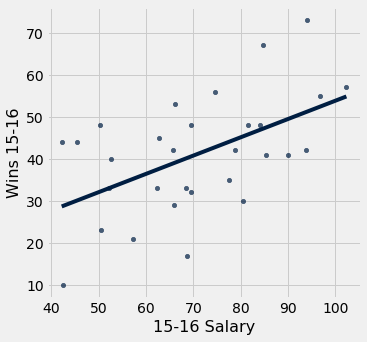

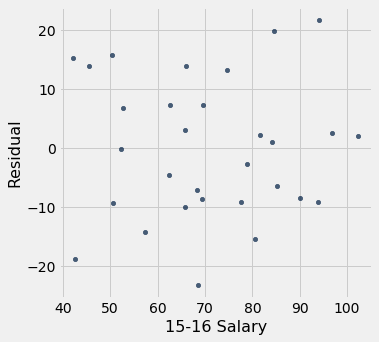

In [32]:
plot_residuals(nba_1516, 2, 1)

By looking at the plots above, we can say there is a linear association between number of wins and salary in 15-16 season. In the residual plot, we can see the points above and below zero are about the same, there is no weird shape, and the points look random. 

## Model

My prediction model gives us the height of the regression line plus some rendom error with mean and standard diviation of residuals. 

In [33]:
def random_error(t, x, y): 
    """Return random errors from normal distribution with mean and standard diviation of residuals. """
    residuals = fit(t, x, y) - t.column(y)
    random_error = np.random.normal(np.mean(residuals), np.std(residuals), len(residuals))
    return random_error

def my_model(t, x, y): 
    """Return predicted value by summing up the height of the regression line and some random errors. """
    return fit(t, x, y) + random_error(t, x, y)

In [34]:
nba_1516_pred = nba_1516.with_column('Predicted Wins', my_model(nba_1516, 2, 1))
nba_1516_pred

Team,Wins 15-16,15-16 Salary,Predicted Wins
Atlanta Hawks,48,69.5731,44.8385
Boston Celtics,48,50.2855,31.168
Brooklyn Nets,21,57.307,49.1841
Charlotte Hornets,48,84.1024,61.0113
Chicago Bulls,42,78.8209,24.2055
Cleveland Cavaliers,57,102.312,50.9145
Dallas Mavericks,42,65.7626,36.6887
Denver Nuggets,33,62.4294,40.7841
Detroit Pistons,44,42.2118,30.0901
Golden State Warriors,73,94.0851,43.6093


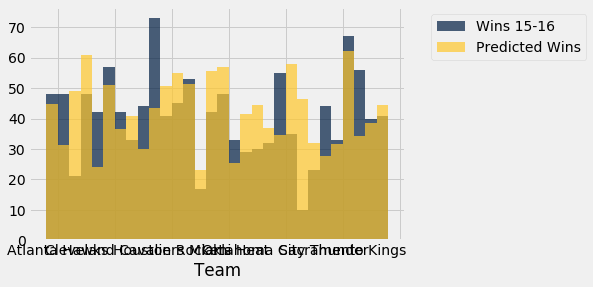

In [35]:
nba_1516_pred.bar('Team', ['Wins 15-16', 'Predicted Wins'])

## Conclusion

Since the correlation between salary and number of wins is not large, around 0.5267, the prediction based on regression line could be quite off. Therefore, there may be other variables affecting the winnings. 